# Tactical Demand Forecasting

The purpose of this notebook is to visualize the time series generation process, the STL decomposition of time series, and a couple of exemplary demand forecasts using different forecasting methods.

In [1]:
!umd --version

urban-meal-delivery, version 0.3.0


### Imports

In [2]:
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from urban_meal_delivery import config, db
from urban_meal_delivery.forecasts import methods, models, timify
from urban_meal_delivery.forecasts.methods import decomposition

In [4]:
%load_ext lab_black

In [5]:
matplotlib.style.use("ggplot")

### Settings

Choose `"Bordeaux"`, `"Lyon"`, or `"Paris"`.

In [6]:
city_name = "Paris"

Choose the `side_length` of the `grid` and the `time_step`. According to the corresponding research paper "Real-time Demand Forecasting for an Urban Delivery Platform", we mainly work with `side_length=1000` and `time_step=60`.

In [7]:
config.GRID_SIDE_LENGTHS  # possible values

[707, 1000, 1414]

In [8]:
side_length = 1000

In [9]:
config.TIME_STEPS  # possible values

[60]

In [10]:
time_step = 60

### Load the Data

In [11]:
city = db.session.query(db.City).filter_by(name=city_name).one()

In [12]:
city

<City(Paris)>

In [13]:
grid = (
    db.session.query(db.Grid)
    .filter_by(city=city)
    .filter_by(side_length=side_length)
    .one()
)

In [14]:
grid

<Grid: 1.0 sqr. km>

The `OrderHistory` class abstracts away the communcation with the database when it comes to generating time series out of the `db.Order` model's table.

In [15]:
orders = timify.OrderHistory(grid=grid, time_step=time_step)

## Pixel Visualization

Choose a `pixel` from the `grid` for which the order time series are generated.

In [16]:
len(grid.pixels)

111

In [17]:
pixel = grid.pixels[15]

In [18]:
pixel.clear_map().draw(order_counts=True)

In [19]:
len(pixel.restaurants)

24

In [20]:
orders.first_order_at(pixel.id)

datetime.datetime(2016, 3, 8, 12, 0)

In [21]:
orders.last_order_at(pixel.id)

datetime.datetime(2017, 1, 31, 22, 0)

## Time Series Generation

Choose the `train_horizon` between `3` and `8` weeks (= length of the historic order time series used to train a prediction model) and the day for which the prediction is to be made (= `predict_at`).

In [22]:
train_horizon = 8

In [23]:
predict_at = dt.datetime(2016, 9, 15, 20)

There are three kinds of time series used for tactical forecasting: "horizontal", "vertical", and "real-time".

In [24]:
orders.make_horizontal_ts(pixel.id, predict_at, train_horizon)[0].tail(5)

start_at
2016-09-10 20:00:00    10
2016-09-11 20:00:00    21
2016-09-12 20:00:00     6
2016-09-13 20:00:00    10
2016-09-14 20:00:00    12
Name: n_orders, dtype: int64

In [25]:
orders.make_vertical_ts(pixel.id, predict_at.date(), train_horizon)[0].tail(5)

start_at
2016-09-14 18:00:00     1
2016-09-14 19:00:00     9
2016-09-14 20:00:00    12
2016-09-14 21:00:00    11
2016-09-14 22:00:00     0
Name: n_orders, dtype: int64

In [26]:
orders.make_realtime_ts(pixel.id, predict_at, train_horizon)[0].tail(5)

start_at
2016-09-15 15:00:00    0
2016-09-15 16:00:00    0
2016-09-15 17:00:00    0
2016-09-15 18:00:00    0
2016-09-15 19:00:00    7
Name: n_orders, dtype: int64

## Time Series Visualization

Generate a vertical `history` time series used to predict the `actuals`. The latter are the order counts that are predicted by the forecasting model below.

In [27]:
history, frequency, actuals = orders.make_vertical_ts(
    pixel.id, predict_at.date(), train_horizon
)

<AxesSubplot:xlabel='start_at'>

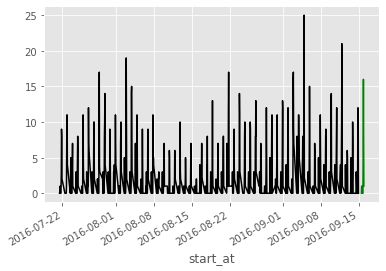

In [28]:
history.plot(style="black")
actuals.plot(style="green")

In [29]:
frequency

84

In [30]:
history

start_at
2016-07-21 11:00:00     0
2016-07-21 12:00:00     0
2016-07-21 13:00:00     0
2016-07-21 14:00:00     1
2016-07-21 15:00:00     0
                       ..
2016-09-14 18:00:00     1
2016-09-14 19:00:00     9
2016-09-14 20:00:00    12
2016-09-14 21:00:00    11
2016-09-14 22:00:00     0
Name: n_orders, Length: 672, dtype: int64

In [31]:
actuals

start_at
2016-09-15 11:00:00     0
2016-09-15 12:00:00     1
2016-09-15 13:00:00     1
2016-09-15 14:00:00     0
2016-09-15 15:00:00     0
2016-09-15 16:00:00     0
2016-09-15 17:00:00     0
2016-09-15 18:00:00     0
2016-09-15 19:00:00     7
2016-09-15 20:00:00    16
2016-09-15 21:00:00     7
2016-09-15 22:00:00     1
Name: n_orders, dtype: int64

## STL Decomposition

For vertical and real-time time series, a decomposition needs to be made. Due to the high `frequency` (i.e., > 12), we use the STL method, which, among others, has a `ns` parameter that must be tuned by the forecaster. To skip the tuning of `ns`, we choose the so-called "periodic" setting and make `ns` a big number.

In [32]:
ns = 999_999_999

In [33]:
history_decomposed = decomposition.stl(history, frequency=frequency, ns=ns)

In [34]:
history_decomposed

,seasonal,trend,residual
start_at,,,
2016-07-21 11:00:00,-2.47545,1.92453,0.55092
2016-07-21 12:00:00,-0.35394,1.93356,-1.57962
2016-07-21 13:00:00,-0.60663,1.94259,-1.33596
2016-07-21 14:00:00,-1.98459,1.95162,1.03297
2016-07-21 15:00:00,-2.48642,1.96065,0.52576
...,...,...,...
2016-09-14 18:00:00,-2.09759,3.06895,0.02864
2016-09-14 19:00:00,4.65025,3.06833,1.28142
2016-09-14 20:00:00,7.14891,3.06771,1.78339


In [35]:
history_decomposed["seasonal"].mean(), history_decomposed["residual"].mean()

(1.1904761900081797e-07, 0.0040629613095238245)

<AxesSubplot:xlabel='start_at'>

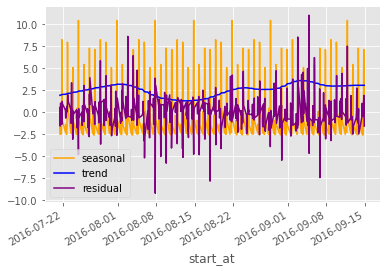

In [36]:
history_decomposed["seasonal"].plot(legend="seasonal", style="orange")
history_decomposed["trend"].plot(legend="trend", style="blue")
history_decomposed["residual"].plot(legend="residual", style="purple")

## Prediction Models

A heuristic derived from the findings of the first research paper determines which forecasting model is used to make the predition. The heuristic is a function of the average daily demand in `history` and `train_horizon` (currently, only `train_horizon=8` is implemented).

In [37]:
orders.avg_daily_demand(pixel.id, predict_at.date(), train_horizon)

30.5

In [38]:
best_model = orders.choose_tactical_model(pixel.id, predict_at.date(), train_horizon)

In [39]:
best_model.name

'hets'

#### *hets* Model

The *hets* model applies the ETS method on a horizontal time series.

In [40]:
best_model.predict(pixel, predict_at, train_horizon)

,actual,prediction,low80,high80,low95,high95
start_at,,,,,,
2016-09-15 20:00:00,16,11.52854,5.53107,17.52601,2.3562,20.70088


#### *pnaive* Model

As a "naive" way, we could simply extrapolate the seasonal component of the decomposed vertical `history` time series linearly and add to it the last observation of the trend component, ignoring the residuals.

In [41]:
seasonal_predictions = methods.extrapolate_season.predict(
    history_decomposed["seasonal"], actuals.index, frequency=frequency
)

seasonal_predictions

,prediction,low80,high80,low95,high95
start_at,,,,,
2016-09-15 11:00:00,-2.47545,NaN,NaN,NaN,NaN
2016-09-15 12:00:00,-0.35394,NaN,NaN,NaN,NaN
2016-09-15 13:00:00,-0.60663,NaN,NaN,NaN,NaN
2016-09-15 14:00:00,-1.98459,NaN,NaN,NaN,NaN
2016-09-15 15:00:00,-2.48642,NaN,NaN,NaN,NaN
2016-09-15 16:00:00,-2.48824,NaN,NaN,NaN,NaN
2016-09-15 17:00:00,-2.49007,NaN,NaN,NaN,NaN
2016-09-15 18:00:00,-1.99189,NaN,NaN,NaN,NaN
2016-09-15 19:00:00,2.38152,NaN,NaN,NaN,NaN


In [42]:
history_decomposed["trend"].tail(10)

start_at
2016-09-14 13:00:00    3.07100
2016-09-14 14:00:00    3.07143
2016-09-14 15:00:00    3.07081
2016-09-14 16:00:00    3.07019
2016-09-14 17:00:00    3.06957
2016-09-14 18:00:00    3.06895
2016-09-14 19:00:00    3.06833
2016-09-14 20:00:00    3.06771
2016-09-14 21:00:00    3.06709
2016-09-14 22:00:00    3.06647
Name: trend, dtype: float64

In [43]:
last_trend = history_decomposed["trend"].iloc[-1]
pnaive = seasonal_predictions + last_trend

pnaive

,prediction,low80,high80,low95,high95
start_at,,,,,
2016-09-15 11:00:00,0.59102,NaN,NaN,NaN,NaN
2016-09-15 12:00:00,2.71253,NaN,NaN,NaN,NaN
2016-09-15 13:00:00,2.45984,NaN,NaN,NaN,NaN
2016-09-15 14:00:00,1.08188,NaN,NaN,NaN,NaN
2016-09-15 15:00:00,0.58005,NaN,NaN,NaN,NaN
2016-09-15 16:00:00,0.57823,NaN,NaN,NaN,NaN
2016-09-15 17:00:00,0.57640,NaN,NaN,NaN,NaN
2016-09-15 18:00:00,1.07458,NaN,NaN,NaN,NaN
2016-09-15 19:00:00,5.44799,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='start_at'>

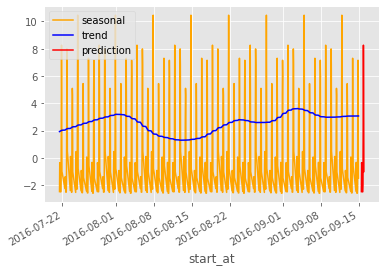

In [44]:
history_decomposed["seasonal"].plot(legend="seasonal", style="orange")
history_decomposed["trend"].plot(legend="trend", style="blue")
seasonal_predictions["prediction"].plot(legend="prediction", style="red")

#### *varima* Model

The *varima* model applies the ARIMA method on a vertical time series. Any prediction method applied on a vertical time series allows us to predict *all* time steps of the day to be predicted at once and, more importantly, before the day actually begins.

In [45]:
varima = models.VerticalARIMAModel(orders)

In [46]:
varima.predict(pixel, predict_at, 8)

,actual,prediction,low80,high80,low95,high95
start_at,,,,,,
2016-09-15 11:00:00,0,0.38215,-1.99851,2.76281,-3.25875,4.02306
2016-09-15 12:00:00,1,2.54113,0.12154,4.96072,-1.15932,6.24157
2016-09-15 13:00:00,1,2.40134,-0.03314,4.83581,-1.32187,6.12455
2016-09-15 14:00:00,0,1.02338,-1.41459,3.46135,-2.70518,4.75193
2016-09-15 15:00:00,0,0.52155,-1.91991,2.96300,-3.21234,4.25543
2016-09-15 16:00:00,0,0.51973,-1.92522,2.96467,-3.21949,4.25894
2016-09-15 17:00:00,0,0.51790,-1.93052,2.96632,-3.22664,4.26243
2016-09-15 18:00:00,0,1.01607,-1.43583,3.46796,-2.73378,4.76591
2016-09-15 19:00:00,7,5.38949,2.93412,7.84485,1.63433,9.14464


#### *rtarima* Model

The *rtarima* model applies the ARIMA method on a real-time time series. Real-time models are *re-trained* after each time step and predict only one observation into the future.

In [47]:
rtarima = models.RealtimeARIMAModel(orders)

In [48]:
rtarima.predict(pixel, predict_at, 8)

,actual,prediction,low80,high80,low95,high95
start_at,,,,,,
2016-09-15 20:00:00,16,11.26066,8.89482,13.62651,7.64242,14.87891


#### *hsma* Model

For pixels with low demand (i.e., averaging between 2.5 and 10 orders per day), a **simple moving average** applied to a horizontal time series is a more robust model.

In [49]:
hsma = models.HorizontalSMAModel(orders)

In [50]:
hsma.predict(pixel, predict_at, 8)

,actual,prediction,low80,high80,low95,high95
start_at,,,,,,
2016-09-15 20:00:00,16,9.928571,NaN,NaN,NaN,NaN


#### *trivial* Model

For pixels with practically no demand (i.e., averaging below 2.5 orders per day), predicting $0$ is the best option as this model is *not* distracted by the noise in the time series.

In [51]:
trivial = models.TrivialModel(orders)

In [52]:
trivial.predict(pixel, predict_at, 8)

,actual,prediction,low80,high80,low95,high95
start_at,,,,,,
2016-09-15 20:00:00,16,0.0,NaN,NaN,NaN,NaN
